In [2]:
## Main test eval loop

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 200

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True
# If you do not want restarts, set to 1 and not 0 as it's the number of times an adv is computed per sample
num_attack_restarts = 10

WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)

for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        
    # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # number of correct preds against worst ensemble of seen or unseen
    num_test_correct_preds_per_domain['worst_seen'] = 0
    num_test_correct_preds_per_domain['worst_unseen'] = 0
    num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0

    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)


        for i_restarts in range(0, num_attack_restarts):
            with ctx_noparamgrad_and_eval(model):
                # Clean data is a domain.
                data_all_domains = {}
                for domain in domains:
                    data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)


                # num_domains = len(data_all_domains)
                # # Initialise count of correct predictions per domain. This array tracks both non fb AND fb domains
                # if len(num_test_correct_preds_per_domain) == 0:
                #     num_test_correct_preds_per_domain = np.zeros(num_domains + num_fb_domains)



                # if len(bool_track_correct_pred_per_domain) == 0:
                #     bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains




            with torch.no_grad():
                track_correct_pred_per_domain(model, data_all_domains, label, domains, bool_track_correct_pred_per_domain)

        # Out of the block that is restarted due to historically testing Boundary attack here, which doesn't require restarts
        for fb_attack_name in fb_attacks:
            # Only notified on the first minibatch to avoid spamming
            if which_batch_test == 1:
                print("Using Foolbox attack ", fb_attack_name)
            fb_attack, metric = get_fb_attack(fb_attack_name)
            if metric == 'L0' or metric == 'L1':
                epsilon = 10.
            elif metric == 'L2':
                epsilon = 0.5
            _, temp_adv, bool_track_preds_temp = fb_attack(fmodel, data, label, epsilons=epsilon)
            # invert the bool because foolbox reports the attack's successes as True and we track the model's successes against adv
            bool_track_correct_pred_per_domain[fb_attack_name] = (~bool_track_preds_temp)


            # # Measure distance between adv example and clean sample with the same norm as the attack, compute the median distance over minibatch
            # temp = temp_adv-data
            # temp = torch.reshape(temp, (100, -1))
            # print(torch.linalg.norm(temp, dim=1, ord=int(metric[-1])).median())


        with torch.no_grad():
            update_num_correct_pred_per_domain(num_test_correct_preds_per_domain, bool_track_correct_pred_per_domain, all_domains)
            num_test_correct_preds_per_domain['worst_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains, skipped_domains_worst_case)
            num_test_correct_preds_per_domain['worst_with_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains)
            num_test_correct_preds_per_domain['worst_seen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, seen_attacks)
            num_test_correct_preds_per_domain['worst_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks)
            num_test_correct_preds_per_domain['worst_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks, skipped_domains_worst_case)
            num_test_correct_preds_per_domain['worst_always_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks)
            num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks, skipped_domains_worst_case)


        # Keep track of bool array to avoid having to redo the very costly perturbation with all attacks in case further metrics are needed
        for domain in all_domains:
            results[domain + "_bool_track_correct_preds"].append(bool_track_correct_pred_per_domain[domain].to('cpu'))

        # Debugging
        print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
        if which_batch_test % 5 == 0:
            # print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
            print("GPU memory allocated in GB:", torch.cuda.memory_allocated()/10**9)
            # Only compute on the first 10 minibatches = 1000 test samples with the default test minibatches of 100
            break
        which_batch_test += 1



    # calculate accuracies
    for keys, _ in num_test_correct_preds_per_domain.items():
        results[keys] = num_test_correct_preds_per_domain[keys] / (which_batch_test * batch_size_test) #len(test_loader.sampler)
    results['num_test_samples'] = (which_batch_test * batch_size_test)
    results['num_attack_restarts'] = num_attack_restarts
    results['model_name'] = model_filenames[model_num]
    results['seen_attacks'] = seen_attacks
    results['unseen_attacks'] = unseen_attacks
    results['always_unseen_attacks'] = always_unseen_attacks
    results['skipped_domains_worst_case'] = skipped_domains_worst_case
    print(results)

    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    np.save(working_dir_of_save + model_filenames[model_num], results)




Files already downloaded and verified
Files already downloaded and verified
Using DataParallel
Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.
Testing, epoch  56 : done with batch  1  out of  50
Testing, epoch  56 : done with batch  2  out of  50
Testing, epoch  56 : done with batch  3  out of  50
Testing, epoch  56 : done with batch  4  out of  50
Testing, epoch  56 : done with batch  5  out of  50
GPU memory allocated in GB: 0.1426048
{'clean': 0.927, 'clean_bool_track_correct_preds': [tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True, False,  True,  True,  True,  Tr

In [7]:
## Eval for increasing epsilon on PGD
# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 100

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)



model.load_state_dict(torch.load('model_ResNet18.pt'))
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)








def eval_PGD_Linf_increasing_eps(list_data_all_domains, epsilons):
    for epsilon in epsilons:
        adversary_PGD_attempt = attacks.LinfPGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=200, eps_iter=2/255, rand_init=True, clip_min=0.0,
            clip_max=1.0, targeted=False)
        list_data_all_domains.append(adversary_PGD_attempt.perturb(data, label))
    return

def eval_PGD_L2_increasing_eps(list_data_all_domains, epsilons):
    for epsilon in epsilons:
        adversary_PGD_attempt = attacks.L2PGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=200, eps_iter=8/255, rand_init=True, clip_min=0.0,
            clip_max=1.0, targeted=False)
        list_data_all_domains.append(adversary_PGD_attempt.perturb(data, label))
    return

def eval_PGD_L1_increasing_eps(list_data_all_domains, epsilons):
    for epsilon in epsilons:
        adversary_PGD_attempt = attacks.L1PGDAttack(
            model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=epsilon,
            nb_iter=200, eps_iter=120/255, rand_init=True, clip_min=0.0,
            clip_max=1.0, targeted=False)
        list_data_all_domains.append(adversary_PGD_attempt.perturb(data, label))
    return


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, label_all_domains, num_domains, bool_correct_per_domain):
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        # print((torch.argmax(preds, dim=1) == label_all_domains[domain]))
        bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, num_domains, only_update_fb=False):
    start_for_loop = 0
    # Avoids reaccumulating the first few entries
    if only_update_fb:
        start_for_loop = num_domains
    for domain in range(start_for_loop, len(bool_correct_per_domain)):
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return






WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]



num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0





num_attack_restarts = 10
epsilons_Linf = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
epsilons_L2 = [0.1, 1.0, 2.0, 3.0, 4.0, 5.0]
epsilons_L1 = [1.0, 20.0, 40.0, 60.0, 80.0, 100.0]





base_domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
domains = ['clean']
for i, epsilons in enumerate([epsilons_L1, epsilons_L2, epsilons_Linf]):
    for epsilon in epsilons:
        domains.append(base_domains[i+1] + "_eps_" + str(epsilon))



######################    
# test the model #
######################
model.eval()
for model_num, model_path in enumerate(model_paths):
    checkpoint = torch.load(model_path)
    starting_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['current_model'])
    model.to(device)

    results = {}
    for domain in domains:
        results[domain] = 0
    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = []
    # number of correct predictions against ensemble of all attacks



    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains

        for i_restarts in range(0, num_attack_restarts):
            with ctx_noparamgrad_and_eval(model):
                # Clean data is a domain
                list_data_all_domains = [data]
                # # Eval at multiple eps for each norm to test for gradient masking
                eval_PGD_L1_increasing_eps(list_data_all_domains, epsilons=epsilons_L1)
                eval_PGD_L2_increasing_eps(list_data_all_domains, epsilons=epsilons_L2)
                eval_PGD_Linf_increasing_eps(list_data_all_domains, epsilons=epsilons_Linf)

                num_domains = len(list_data_all_domains)
                # Initialise count of correct predictions per domain. This array tracks both non fb AND fb domains
                if len(num_test_correct_preds_per_domain) == 0:
                    num_test_correct_preds_per_domain = np.zeros(num_domains)

                list_label_all_domains = [label] * num_domains

                if len(bool_track_correct_pred_per_domain) == 0:
                    bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains




            with torch.no_grad():
                track_correct_pred_per_domain(model, list_data_all_domains, list_label_all_domains, num_domains, bool_track_correct_pred_per_domain)

        with torch.no_grad():
            update_num_correct_pred_per_domain(num_test_correct_preds_per_domain, bool_track_correct_pred_per_domain, num_domains)


        # Debugging
        print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
        if which_batch_test % 10 == 0:
            # print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
            print("GPU memory allocated in GB:", torch.cuda.memory_allocated()/10**9)
            break
        which_batch_test += 1



    # calculate average loss over an epoch
    test_acc_per_domain = num_test_correct_preds_per_domain / (which_batch_test * batch_size_test) #len(test_loader.sampler)
    results['num_test_samples'] = (which_batch_test * batch_size_test)
    results['num_attack_restarts'] = num_attack_restarts
    results['model_name'] = model_filenames[model_num]
    for i, domain in enumerate(domains):
        results[domain] = test_acc_per_domain[i]
    print(results)

    working_dir_of_save = WORKING_DIR + "increasing_eps/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "increasing_eps/")
    np.save(working_dir_of_save + model_filenames[model_num], results)


Files already downloaded and verified
Files already downloaded and verified
Using DataParallel
Testing, epoch  371 : done with batch  1  out of  100
Testing, epoch  371 : done with batch  2  out of  100
Testing, epoch  371 : done with batch  3  out of  100
Testing, epoch  371 : done with batch  4  out of  100
Testing, epoch  371 : done with batch  5  out of  100
Testing, epoch  371 : done with batch  6  out of  100
Testing, epoch  371 : done with batch  7  out of  100
Testing, epoch  371 : done with batch  8  out of  100
Testing, epoch  371 : done with batch  9  out of  100
Testing, epoch  371 : done with batch  10  out of  100
GPU memory allocated in GB: 0.276179968
{'clean': 0.79, 'PGD_L1_std_eps_1.0': 0.732, 'PGD_L1_std_eps_20.0': 0.459, 'PGD_L1_std_eps_40.0': 0.411, 'PGD_L1_std_eps_60.0': 0.42, 'PGD_L1_std_eps_80.0': 0.401, 'PGD_L1_std_eps_100.0': 0.387, 'PGD_L2_std_eps_0.1': 0.755, 'PGD_L2_std_eps_1.0': 0.319, 'PGD_L2_std_eps_2.0': 0.038, 'PGD_L2_std_eps_3.0': 0.004, 'PGD_L2_std_e

In [1]:
# mask = torch.BoolTensor([False, False, False])
# a = torch.rand(3,6,2)
# print(a)
# b = len(a[mask, :, :])
# if b == 0:
#     c = None
# print(c == None)

# for domain in domains:
    # print(domain, data_all_domains[domain].shape)
import os
import numpy as np
# import torch
WORKING_DIR = "results/CIFAR10/"
RESULTS_PATH = WORKING_DIR + "AA_stronger/"
for root, dirs, files in os.walk(RESULTS_PATH):
    model_filenames = files
    model_paths = [RESULTS_PATH + file for file in files]
for path in model_paths:
    temp = np.load(path, allow_pickle = True).item()
    results = {}
    for k, v in temp.items():
        if "bool" in k.split('_'):
            continue
        results[k] = v
    # print(results['model_name'])
    print(path, results, '\n\n')
# PATH = "results/CIFAR10/test_accs/model_PGDs_REx_370.pt.npy"
# for domain in all_domains:
#     for k in range(len(results[domain + '_bool_track_correct_preds'])):
#         results[domain + '_bool_track_correct_preds'][k] = results[domain + '_bool_track_correct_preds'][k].to('cpu')
# results = np.save(PATH, results)

results/CIFAR10/AA_stronger/model_MSD_REx_99.pt.npy {'Autoattack_stronger': 0.268} 


results/CIFAR10/AA_stronger/model_MSD_ERM_51.pt.npy {'Autoattack_stronger': 0.25} 


results/CIFAR10/AA_stronger/model_PGD_Linf_103.pt.npy {'Autoattack_stronger': 0.259} 


results/CIFAR10/AA_stronger/model_std_ERM_140.pt.npy {'Autoattack_stronger': 0.156} 


results/CIFAR10/AA_stronger/model_std_REx_110.pt.npy {'Autoattack_stronger': 0.242} 




In [31]:
model.module.load_state_dict(torch.load('results/CIFAR10/models/model_std_REx_110.pt')['current_model'])
for _, (data, label) in enumerate(test_loader):
    data, label = data.to(device), label.to(device)
    preds = model(data)
    print((torch.argmax(preds, dim=1) == label).sum().item()/200)
    break

0.805


Files already downloaded and verified
Files already downloaded and verified
Using DataParallel
Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.


<Figure size 432x288 with 0 Axes>

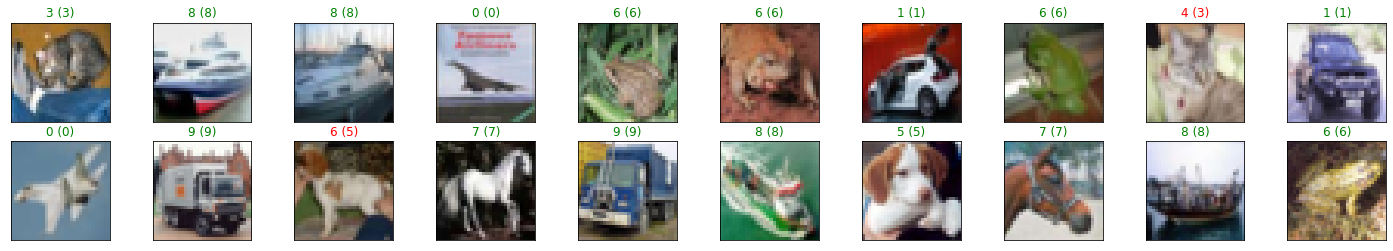

<Figure size 432x288 with 0 Axes>

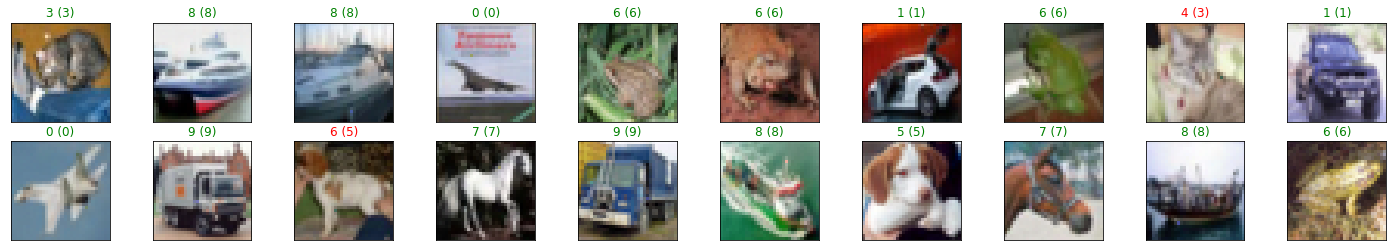

<Figure size 432x288 with 0 Axes>

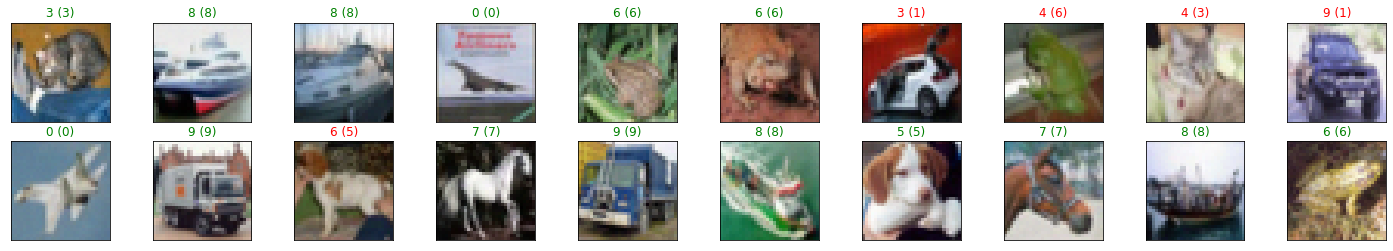

<Figure size 432x288 with 0 Axes>

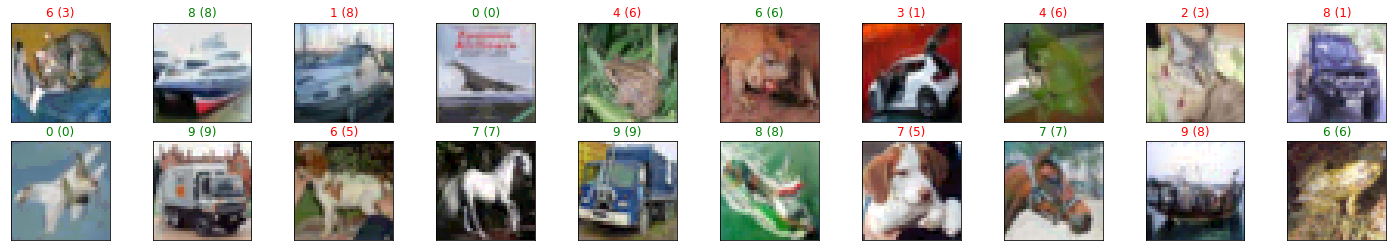

<Figure size 432x288 with 0 Axes>

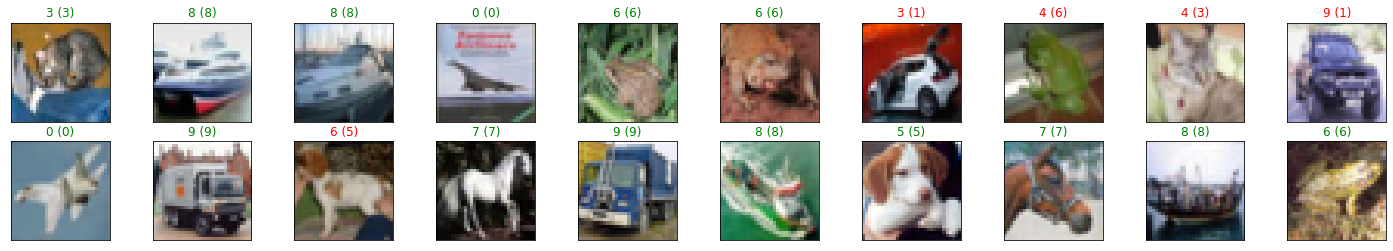

<Figure size 432x288 with 0 Axes>

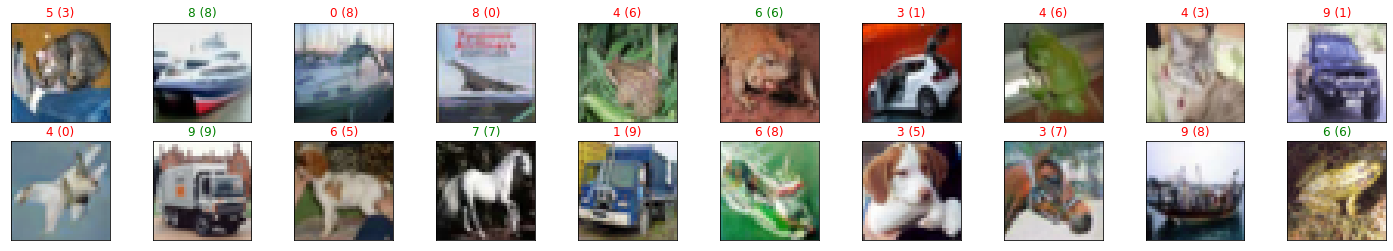

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

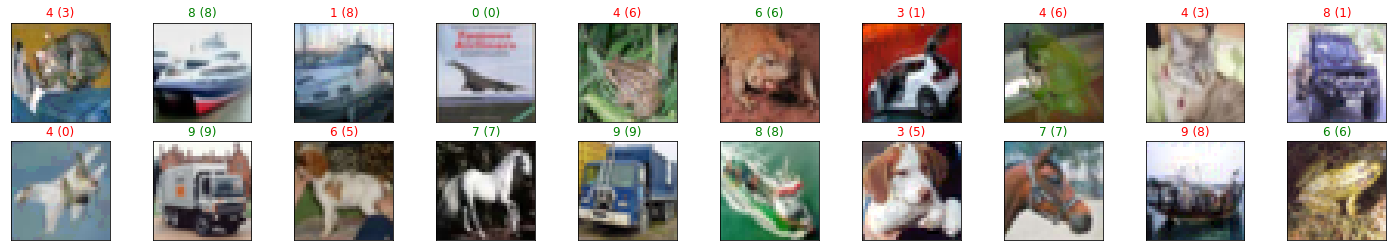

<Figure size 432x288 with 0 Axes>

Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.


<Figure size 432x288 with 0 Axes>

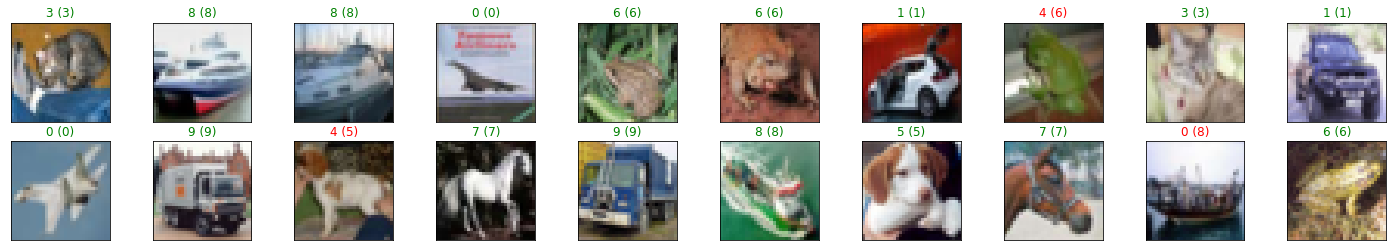

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

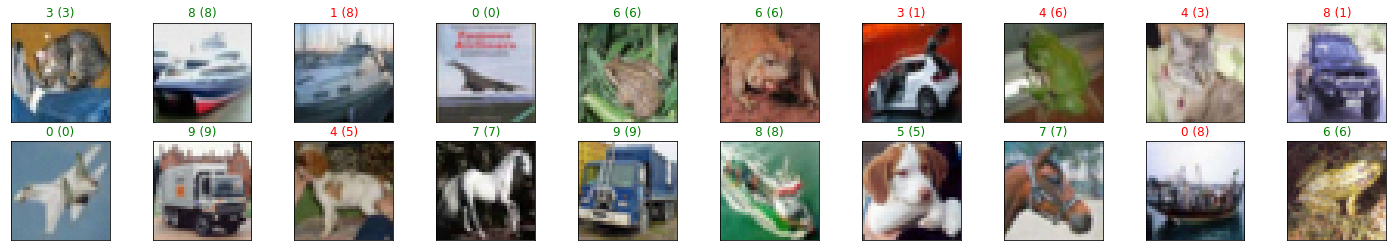

<Figure size 432x288 with 0 Axes>

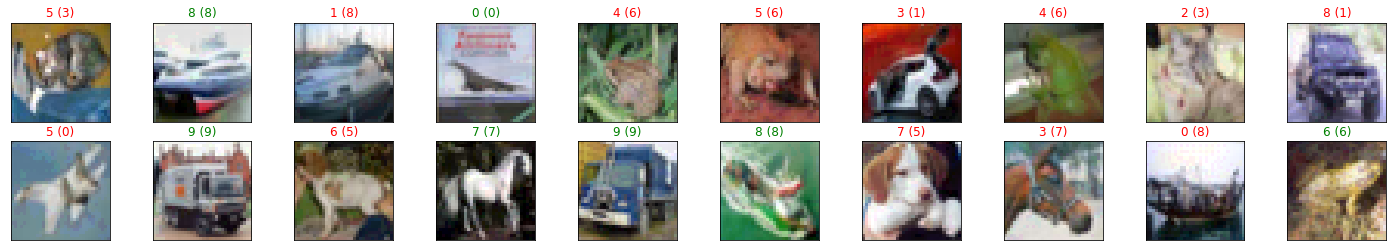

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

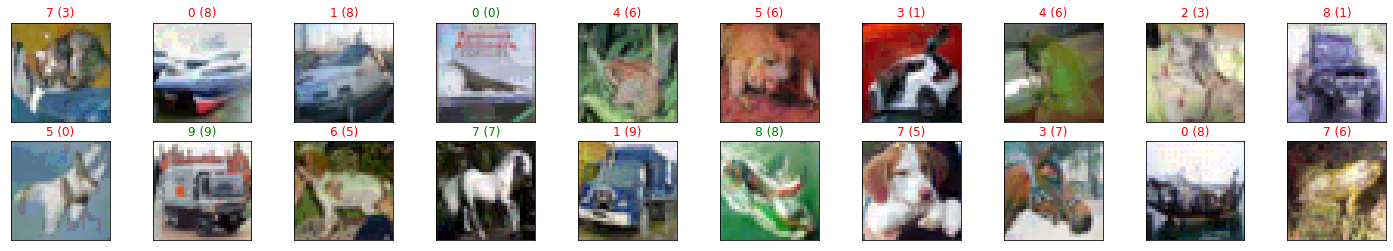

<Figure size 432x288 with 0 Axes>

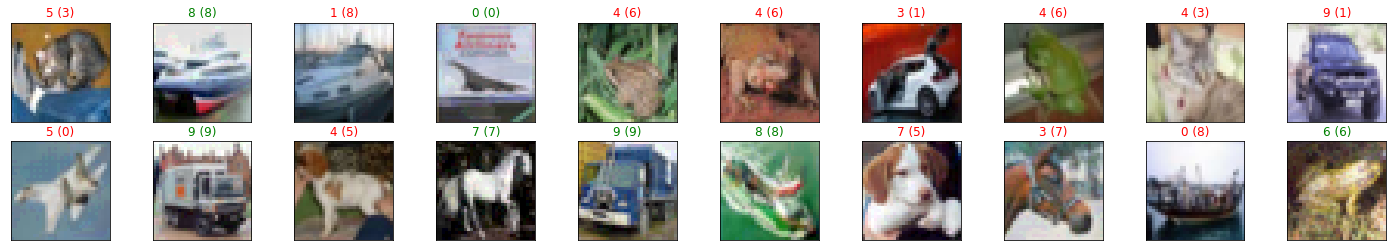

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

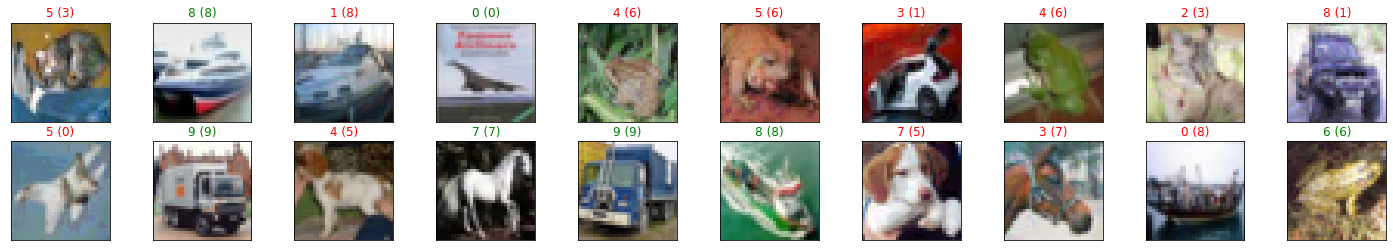

<Figure size 432x288 with 0 Axes>

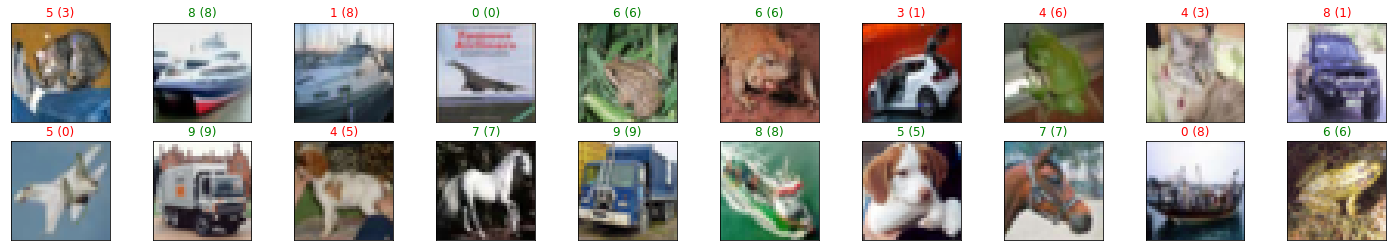

Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.


<Figure size 432x288 with 0 Axes>

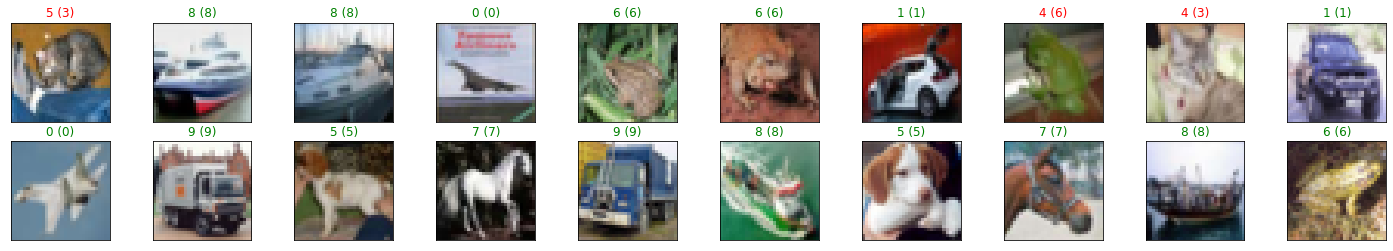

<Figure size 432x288 with 0 Axes>

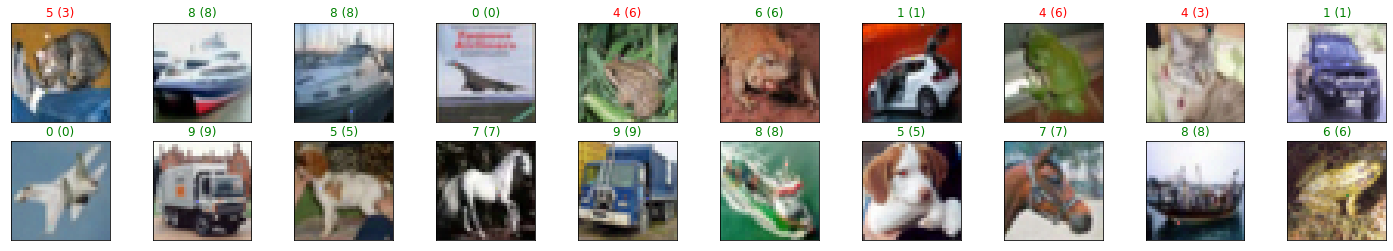

<Figure size 432x288 with 0 Axes>

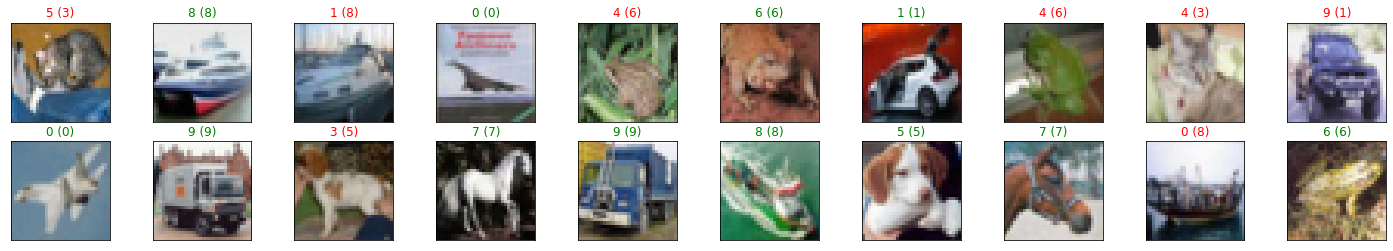

<Figure size 432x288 with 0 Axes>

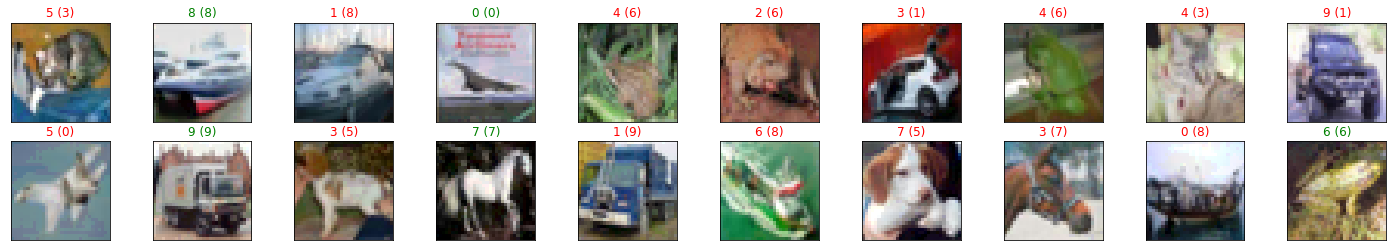

<Figure size 432x288 with 0 Axes>

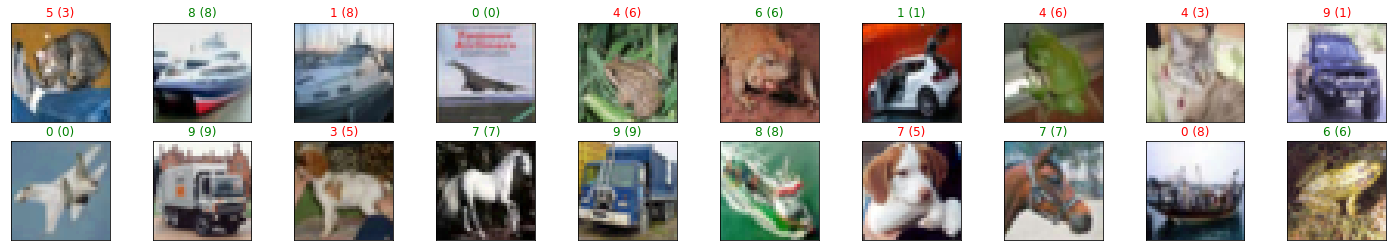

<Figure size 432x288 with 0 Axes>

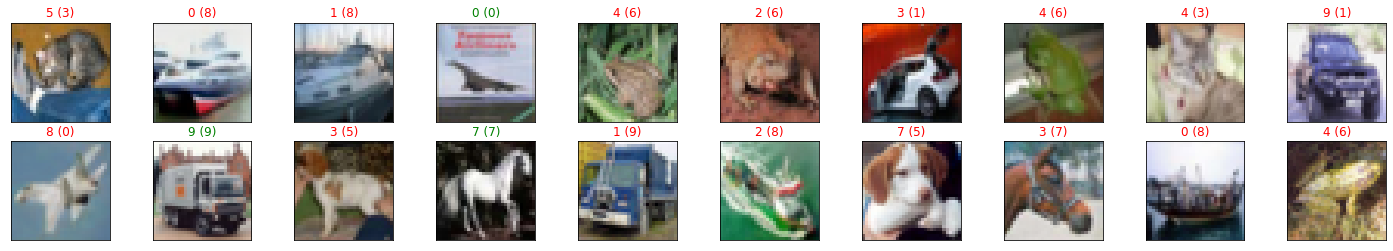

<Figure size 432x288 with 0 Axes>

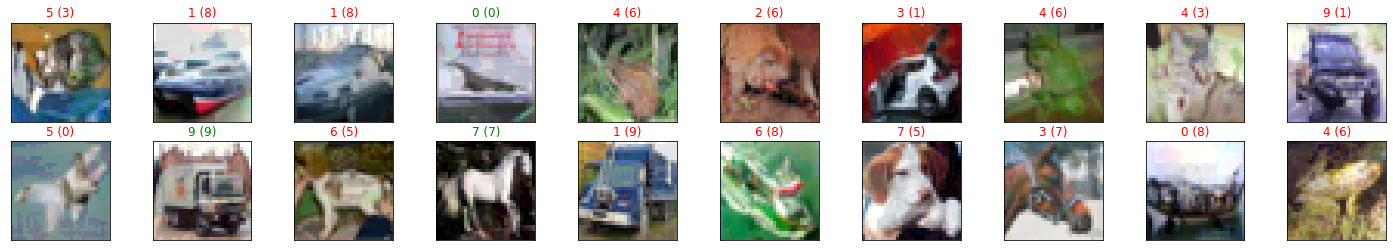

<Figure size 432x288 with 0 Axes>

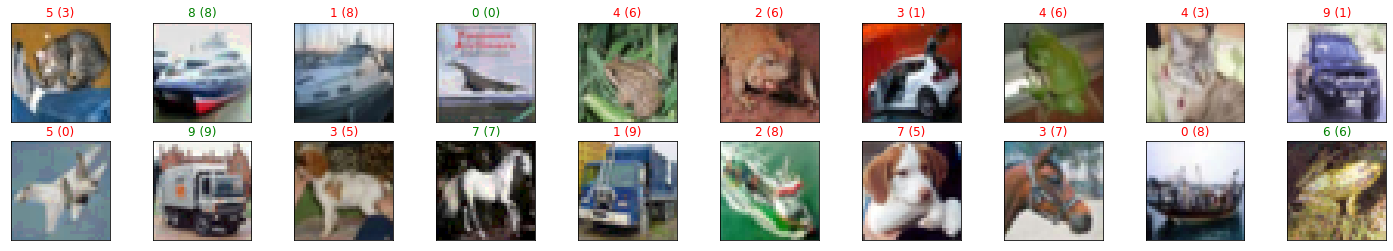

<Figure size 432x288 with 0 Axes>

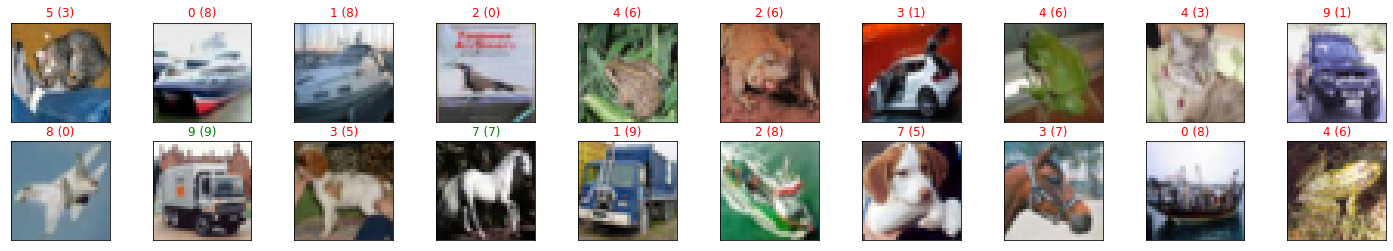

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

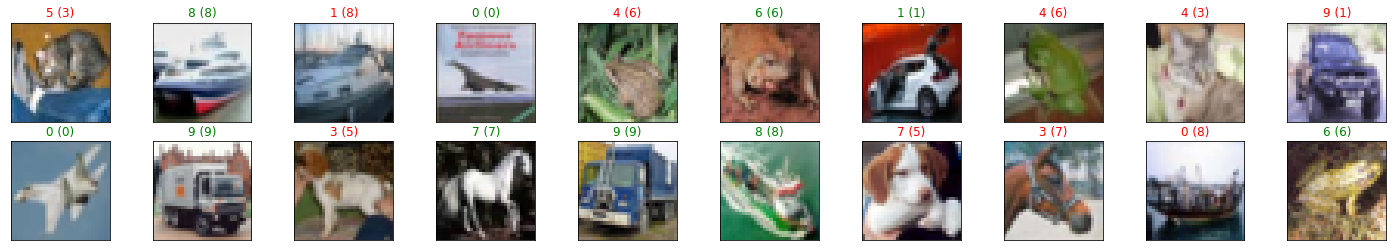

In [16]:
## Generate samples from the different domains and save them

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 20

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True


WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)


for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        
    # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # number of correct preds against worst ensemble of seen or unseen
    num_test_correct_preds_per_domain['worst_seen'] = 0
    num_test_correct_preds_per_domain['worst_unseen'] = 0
    num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0

    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)



        with ctx_noparamgrad_and_eval(model):
            # Clean data is a domain.
            data_all_domains = {}
            for domain in domains:
                data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)
                import matplotlib.pyplot as plt
                %matplotlib inline

                # obtain one batch of training images
                images = data_all_domains[domain]
                # get sample outputs
                output = model(images)


                # convert output probabilities to predicted class
                _, preds = torch.max(output, 1)
                # prep images for display
                images = images.cpu().numpy()
                images = images.swapaxes(1,2)
                images = images.swapaxes(2,3)
                # plot the images in the batch, along with predicted and true labels
                plt.clf()
                fig = plt.figure(figsize=(25, 4))
                for idx in np.arange(20):
                    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
                    ax.imshow(np.squeeze(images[idx]))#, cmap='rgb')
                    ax.set_title("{} ({})".format(str(preds[idx].item()), str(label[idx].item())),
                                 color=("green" if preds[idx]==label[idx] else "red"))
                plt.pause(0.0001)
                fig.savefig("figures/adversarial_examples_CIFAR10/" + model_filenames[model_num][:-3] + domain + '.png')
                fig.show()
                plt.close()

        break


    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    # np.save(working_dir_of_save + model_filenames[model_num], results)








In [1]:
## Eval on CW with cutoff based on eps threshold

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 200

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True


WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []#['PA_L1'] #['PA_L1', 'PA_L2', 'BA_L2']
domains = ['CW_base']#, 'CW_mod']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)


for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    how_many_smaller_total = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        how_many_smaller_total[domain] = 0
        
    # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # number of correct preds against worst ensemble of seen or unseen
    num_test_correct_preds_per_domain['worst_seen'] = 0
    num_test_correct_preds_per_domain['worst_unseen'] = 0
    num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0



    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)



        with ctx_noparamgrad_and_eval(model):
            # Clean data is a domain.
            data_all_domains = {}
            for domain in domains:
                data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)
                    


        with torch.no_grad():
            for domain in domains:
                epsilons = ((data_all_domains['CW_base'].view(batch_size_test, -1) - data.view(batch_size_test, -1))**2).sum(1).sqrt()
                # print(data_all_domains['CW_base'].view(batch_size_test, -1).size())
                # print(epsilons)
                # Reject adv examples not in the L2 ball of radius 0.5
                mask = epsilons <= 0.5
                how_many_smaller = mask.sum().item()
                if how_many_smaller > 0:
                    masked_data_domain = data_all_domains[domain][mask, :, :, :]
                    num_test_correct_preds_per_domain[domain] += (torch.argmax(model(masked_data_domain), dim=1) == label[mask]).sum().item()
                    how_many_smaller_total[domain] += how_many_smaller
        if which_batch_test == 10:
            break
        which_batch_test += 1

    print(model_path)
    print(how_many_smaller_total['CW_base'])
    print(num_test_correct_preds_per_domain['CW_base']/how_many_smaller_total['CW_base'])
    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    # np.save(working_dir_of_save + model_filenames[model_num], results)








Files already downloaded and verified
Files already downloaded and verified
Using DataParallel
Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.
results/CIFAR10/models/model_PGD_L2_103.pt
761
0.12352168199737187


In [18]:
## Eval PAT model

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 200

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    
    # Handle case of PAT model. It's not actually exactly PGD L2, but it is the closest attack to what PAT models see during training.
    if model_name.endswith(".ckpt.pth"):
        seen_attacks = ['PGD_L2_std']

  
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True
# If you do not want restarts, set to 1 and not 0 as it's the number of times an adv is computed per sample
num_attack_restarts = 10

WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std', 'Deepfool_base', 'CW_base',
                'PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)

for model_num, model_path in enumerate(model_paths):
    # Loading the PAT model is slightly different
    checkpoint = torch.load(model_path)
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['model'])
        print("Successfully loaded onto model.module.")
    


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        
    # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # number of correct preds against worst ensemble of seen or unseen
    num_test_correct_preds_per_domain['worst_seen'] = 0
    num_test_correct_preds_per_domain['worst_unseen'] = 0
    num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0

    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)


        for i_restarts in range(0, num_attack_restarts):
            with ctx_noparamgrad_and_eval(model):
                # Clean data is a domain.
                data_all_domains = {}
                for domain in domains:
                    data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)


                # num_domains = len(data_all_domains)
                # # Initialise count of correct predictions per domain. This array tracks both non fb AND fb domains
                # if len(num_test_correct_preds_per_domain) == 0:
                #     num_test_correct_preds_per_domain = np.zeros(num_domains + num_fb_domains)



                # if len(bool_track_correct_pred_per_domain) == 0:
                #     bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains




            with torch.no_grad():
                track_correct_pred_per_domain(model, data_all_domains, label, domains, bool_track_correct_pred_per_domain)

        # Out of the block that is restarted due to historically testing Boundary attack here, which doesn't require restarts
        for fb_attack_name in fb_attacks:
            # Only notified on the first minibatch to avoid spamming
            if which_batch_test == 1:
                print("Using Foolbox attack ", fb_attack_name)
            fb_attack, metric = get_fb_attack(fb_attack_name)
            if metric == 'L0' or metric == 'L1':
                epsilon = 10.
            elif metric == 'L2':
                epsilon = 0.5
            _, temp_adv, bool_track_preds_temp = fb_attack(fmodel, data, label, epsilons=epsilon)
            # invert the bool because foolbox reports the attack's successes as True and we track the model's successes against adv
            bool_track_correct_pred_per_domain[fb_attack_name] = (~bool_track_preds_temp)


            # # Measure distance between adv example and clean sample with the same norm as the attack, compute the median distance over minibatch
            # temp = temp_adv-data
            # temp = torch.reshape(temp, (100, -1))
            # print(torch.linalg.norm(temp, dim=1, ord=int(metric[-1])).median())


        with torch.no_grad():
            update_num_correct_pred_per_domain(num_test_correct_preds_per_domain, bool_track_correct_pred_per_domain, all_domains)
            num_test_correct_preds_per_domain['worst_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains, skipped_domains_worst_case)
            num_test_correct_preds_per_domain['worst_with_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains)
            num_test_correct_preds_per_domain['worst_seen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, seen_attacks)
            num_test_correct_preds_per_domain['worst_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks)
            num_test_correct_preds_per_domain['worst_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks, skipped_domains_worst_case)
            num_test_correct_preds_per_domain['worst_always_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks)
            num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks, skipped_domains_worst_case)


        # Keep track of bool array to avoid having to redo the very costly perturbation with all attacks in case further metrics are needed
        for domain in all_domains:
            results[domain + "_bool_track_correct_preds"].append(bool_track_correct_pred_per_domain[domain].to('cpu'))

        # Debugging
        print("Testing, model ", model_filenames[model_num], ": done with batch ", which_batch_test, " out of ", num_test_batches)
        if which_batch_test % 5 == 0:
            # print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
            print("GPU memory allocated in GB:", torch.cuda.memory_allocated()/10**9)
            # Only compute on the first 10 minibatches = 1000 test samples with the default test minibatches of 100
            break
        which_batch_test += 1



    # calculate accuracies
    for keys, _ in num_test_correct_preds_per_domain.items():
        results[keys] = num_test_correct_preds_per_domain[keys] / (which_batch_test * batch_size_test) #len(test_loader.sampler)
    results['num_test_samples'] = (which_batch_test * batch_size_test)
    results['num_attack_restarts'] = num_attack_restarts
    results['model_name'] = model_filenames[model_num]
    results['seen_attacks'] = seen_attacks
    results['unseen_attacks'] = unseen_attacks
    results['always_unseen_attacks'] = always_unseen_attacks
    results['skipped_domains_worst_case'] = skipped_domains_worst_case
    print(results)

    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    np.save(working_dir_of_save + model_filenames[model_num], results)




Files already downloaded and verified


KeyboardInterrupt: 

In [ ]:
## Eval on Autoattack_stronger which has larger epsilon

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 200

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_unseen_stronger = AutoAttack(model, norm='Linf', eps=12/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_stronger":
        return adversary_autoattack_unseen_stronger.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True
# If you do not want restarts, set to 1 and not 0 as it's the number of times an adv is computed per sample
num_attack_restarts = 10

WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['Autoattack_stronger']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)

for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    

    # seen_attacks = get_seen_attacks(model_filenames[model_num])
    # unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    # always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        


    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)


        for i_restarts in range(0, num_attack_restarts):
            with ctx_noparamgrad_and_eval(model):
                # Clean data is a domain.
                data_all_domains = {}
                for domain in domains:
                    data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)


                # num_domains = len(data_all_domains)
                # # Initialise count of correct predictions per domain. This array tracks both non fb AND fb domains
                # if len(num_test_correct_preds_per_domain) == 0:
                #     num_test_correct_preds_per_domain = np.zeros(num_domains + num_fb_domains)



                # if len(bool_track_correct_pred_per_domain) == 0:
                #     bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains




            with torch.no_grad():
                track_correct_pred_per_domain(model, data_all_domains, label, domains, bool_track_correct_pred_per_domain)




        with torch.no_grad():
            update_num_correct_pred_per_domain(num_test_correct_preds_per_domain, bool_track_correct_pred_per_domain, all_domains)
            # num_test_correct_preds_per_domain['worst_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains, skipped_domains_worst_case)
            # num_test_correct_preds_per_domain['worst_with_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains)
            # num_test_correct_preds_per_domain['worst_seen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, seen_attacks)
            # num_test_correct_preds_per_domain['worst_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks)
            # num_test_correct_preds_per_domain['worst_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks, skipped_domains_worst_case)
            # num_test_correct_preds_per_domain['worst_always_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks)
            # num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks, skipped_domains_worst_case)


        # Keep track of bool array to avoid having to redo the very costly perturbation with all attacks in case further metrics are needed
        for domain in all_domains:
            results[domain + "_bool_track_correct_preds"].append(bool_track_correct_pred_per_domain[domain].to('cpu'))

        # Debugging
        print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
        if which_batch_test % 5 == 0:
            # print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
            print("GPU memory allocated in GB:", torch.cuda.memory_allocated()/10**9)
            # Only compute on the first 10 minibatches = 1000 test samples with the default test minibatches of 100
            break
        which_batch_test += 1



    # calculate accuracies
    for keys, _ in num_test_correct_preds_per_domain.items():
        results[keys] = num_test_correct_preds_per_domain[keys] / (which_batch_test * batch_size_test) #len(test_loader.sampler)
 
    print(results)

    working_dir_of_save = WORKING_DIR + "AA_stronger/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "AA_stronger/")
    np.save(working_dir_of_save + model_filenames[model_num], results)




In [ ]:
## Test eval loop for non-Lp attacks

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack
import recoloradv.utils as radv
import recoloradv.mister_ed.utils.pytorch_utils as radv_torchutils
import torchattacks

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 200

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)

adversary_recoloradv = radv.get_attack_from_name('recoloradv', model, radv_torchutils.IdentityNormalize())

adversary_stadv = radv.get_attack_from_name('stadv', model, radv_torchutils.IdentityNormalize())



def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == 'recoloradv':
        return adversary_recoloradv.attack(masked_data, masked_label)[0].detach()
    if domain_name == 'stadv':
        return adversary_stadv.attack(masked_data, masked_label)[0].detach()











def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True
# If you do not want restarts, set to 1 and not 0 as it's the number of times an adv is computed per sample
num_attack_restarts = 1

WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['onepixel', 'recoloradv', 'stadv']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)

for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    try: 
        starting_epoch = checkpoint['epoch']
        # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
        # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
        # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
        try:
            model.load_state_dict(checkpoint['current_model'])
        except:
            print("Failed to load model onto model, attempting to load onto model.module...")
            model.module.load_state_dict(checkpoint['current_model'])
            print("Successfully loaded onto model.module.")
        model_successfully_loaded = True
    
    except:
        print("Model not stored on 'current_model' key")
        model_successfully_loaded = False

    if not model_successfully_loaded:
        try:
            # Loading the PAT model is slightly different
            checkpoint = torch.load(model_path)
            # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
            # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
            # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
            try:
                model.load_state_dict(checkpoint['model'])
            except:
                print("Failed to load model onto model, attempting to load onto model.module...")
                model.module.load_state_dict(checkpoint['model'])
                print("Successfully loaded onto model.module.")
            # Assuming epoch is only number in the name of the file
            numbers_in_filename = [int(string) for string in model_filenames[model_num].split('.') if string.isdigit()]
            if len(numbers_in_filename) == 1:
                starting_epoch = numbers_in_filename[0]
                print("Starting epoch guessed from filename:", starting_epoch)
            else:
                raise ValueError("Starting epoch could not be guessed from filename. Case not handled.")
        except:
            raise ValueError("Did not succeed in loading model -- check the key used to store model in the checkpoint loaded.")


    


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        
    # # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    # num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    # num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # # number of correct preds against worst ensemble of seen or unseen
    # num_test_correct_preds_per_domain['worst_seen'] = 0
    # num_test_correct_preds_per_domain['worst_unseen'] = 0
    # num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    # num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    # num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0

    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)


        for i_restarts in range(0, num_attack_restarts):
            with ctx_noparamgrad_and_eval(model):
                # Clean data is a domain.
                data_all_domains = {}
                for domain in domains:
                    data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)


                # num_domains = len(data_all_domains)
                # # Initialise count of correct predictions per domain. This array tracks both non fb AND fb domains
                # if len(num_test_correct_preds_per_domain) == 0:
                #     num_test_correct_preds_per_domain = np.zeros(num_domains + num_fb_domains)



                # if len(bool_track_correct_pred_per_domain) == 0:
                #     bool_track_correct_pred_per_domain = [torch.ones_like(label)] * num_domains




            with torch.no_grad():
                track_correct_pred_per_domain(model, data_all_domains, label, domains, bool_track_correct_pred_per_domain)

        # # Out of the block that is restarted due to historically testing Boundary attack here, which doesn't require restarts
        # for fb_attack_name in fb_attacks:
        #     # Only notified on the first minibatch to avoid spamming
        #     if which_batch_test == 1:
        #         print("Using Foolbox attack ", fb_attack_name)
        #     fb_attack, metric = get_fb_attack(fb_attack_name)
        #     if metric == 'L0' or metric == 'L1':
        #         epsilon = 10.
        #     elif metric == 'L2':
        #         epsilon = 0.5
        #     _, temp_adv, bool_track_preds_temp = fb_attack(fmodel, data, label, epsilons=epsilon)
        #     # invert the bool because foolbox reports the attack's successes as True and we track the model's successes against adv
        #     bool_track_correct_pred_per_domain[fb_attack_name] = (~bool_track_preds_temp)


        #     # # Measure distance between adv example and clean sample with the same norm as the attack, compute the median distance over minibatch
        #     # temp = temp_adv-data
        #     # temp = torch.reshape(temp, (100, -1))
        #     # print(torch.linalg.norm(temp, dim=1, ord=int(metric[-1])).median())


        with torch.no_grad():
            update_num_correct_pred_per_domain(num_test_correct_preds_per_domain, bool_track_correct_pred_per_domain, all_domains)
            # num_test_correct_preds_per_domain['worst_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains, skipped_domains_worst_case)
            # num_test_correct_preds_per_domain['worst_with_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, all_domains)
            # num_test_correct_preds_per_domain['worst_seen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, seen_attacks)
            # num_test_correct_preds_per_domain['worst_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks)
            # num_test_correct_preds_per_domain['worst_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, unseen_attacks, skipped_domains_worst_case)
            # num_test_correct_preds_per_domain['worst_always_unseen'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks)
            # num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] += get_num_correct_worst_case(bool_track_correct_pred_per_domain, always_unseen_attacks, skipped_domains_worst_case)


        # Keep track of bool array to avoid having to redo the very costly perturbation with all attacks in case further metrics are needed
        for domain in all_domains:
            results[domain + "_bool_track_correct_preds"].append(bool_track_correct_pred_per_domain[domain].to('cpu'))

        # Debugging
        print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
        if which_batch_test % 5 == 0:
            # print("Testing, epoch ", starting_epoch, ": done with batch ", which_batch_test, " out of ", num_test_batches)
            print("GPU memory allocated in GB:", torch.cuda.memory_allocated()/10**9)
            # Only compute on the first 10 minibatches = 1000 test samples with the default test minibatches of 100
            break
        which_batch_test += 1



    # calculate accuracies
    for keys, _ in num_test_correct_preds_per_domain.items():
        results[keys] = num_test_correct_preds_per_domain[keys] / (which_batch_test * batch_size_test) #len(test_loader.sampler)
    results['num_test_samples'] = (which_batch_test * batch_size_test)
    results['num_attack_restarts'] = num_attack_restarts
    results['model_name'] = model_filenames[model_num]
    # results['seen_attacks'] = seen_attacks
    # results['unseen_attacks'] = unseen_attacks
    # results['always_unseen_attacks'] = always_unseen_attacks
    # results['skipped_domains_worst_case'] = skipped_domains_worst_case
    print(results)

    working_dir_of_save = WORKING_DIR + "test_accs_non_Lp/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs_non_Lp/")
    np.save(working_dir_of_save + model_filenames[model_num], results)




In [24]:
import os
import numpy as np
# import torch
WORKING_DIR = "results/CIFAR10/"
RESULTS_PATH = WORKING_DIR + "test_accs_non_Lp/"
for root, dirs, files in os.walk(RESULTS_PATH):
    model_filenames = files
    model_paths = [RESULTS_PATH + file for file in files]
for path in model_paths:
    temp = np.load(path, allow_pickle = True).item()
    results = {}
    for k, v in temp.items():
        if "bool" in k.split('_'):
            continue
        results[k] = v
    # print(results['model_name'])
    print(path, results, '\n\n')

results/CIFAR10/test_accs_non_Lp/model_PGD_Linf_103.pt.npy {'recoloradv': 0.504, 'stadv': 0.12, 'num_test_samples': 1000, 'num_attack_restarts': 1, 'model_name': 'model_PGD_Linf_103.pt'} 


results/CIFAR10/test_accs_non_Lp/model_MSD_ERM_51.pt.npy {'recoloradv': 0.56, 'stadv': 0.175, 'num_test_samples': 1000, 'num_attack_restarts': 1, 'model_name': 'model_MSD_ERM_51.pt'} 


results/CIFAR10/test_accs_non_Lp/model_MSD_REx_99.pt.npy {'recoloradv': 0.583, 'stadv': 0.227, 'num_test_samples': 1000, 'num_attack_restarts': 1, 'model_name': 'model_MSD_REx_99.pt'} 


results/CIFAR10/test_accs_non_Lp/model_std_ERM_140.pt.npy {'recoloradv': 0.245, 'stadv': 0.041, 'num_test_samples': 1000, 'num_attack_restarts': 1, 'model_name': 'model_std_ERM_140.pt'} 


results/CIFAR10/test_accs_non_Lp/model_std_REx_110.pt.npy {'recoloradv': 0.635, 'stadv': 0.318, 'num_test_samples': 1000, 'num_attack_restarts': 1, 'model_name': 'model_std_REx_110.pt'} 


results/CIFAR10/test_accs_non_Lp/model_ERM_clean_56.pt.npy 

Files already downloaded and verified
Files already downloaded and verified
Using DataParallel
Failed to load model onto model, attempting to load onto model.module...
Successfully loaded onto model.module.


<Figure size 432x288 with 0 Axes>

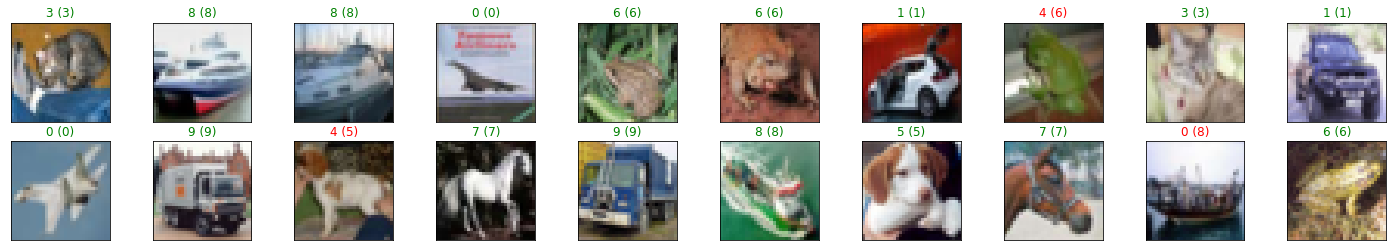

<Figure size 432x288 with 0 Axes>

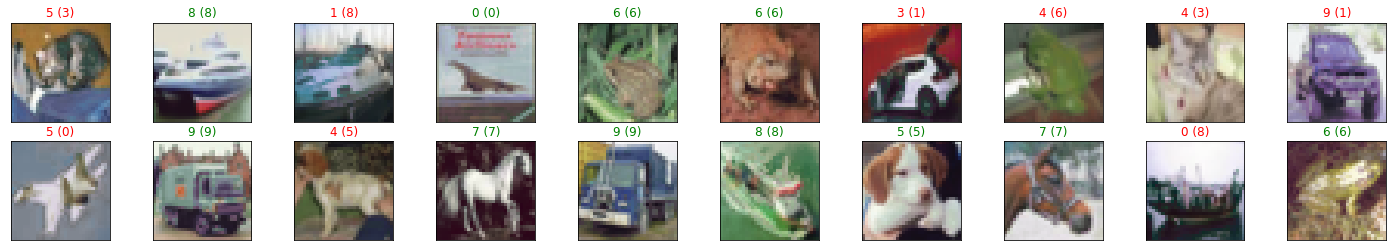

<Figure size 432x288 with 0 Axes>

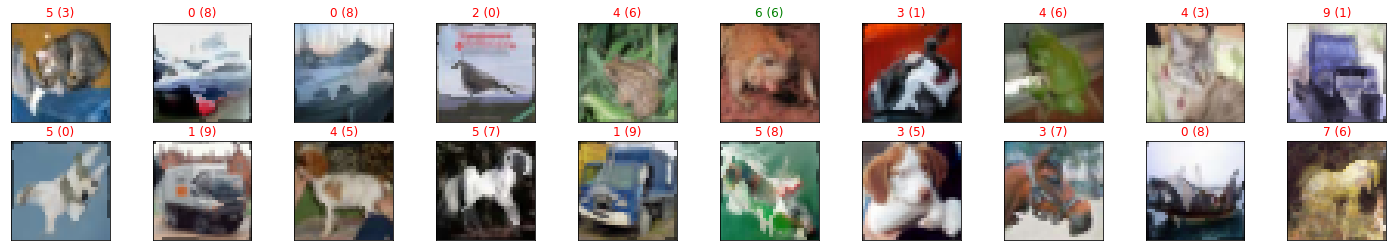

In [13]:
## Visualise non-Lp attacks

# clear memory
from IPython import get_ipython
get_ipython().magic('reset -sf') 

import numpy as np
import torch
import time
timer = 0

from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

import torch.nn as nn
import torch.nn.functional as F

import advertorch.attacks as attacks
from attacks.deepfool import DeepfoolLinfAttack
import torch.nn as nn
from autoattack import AutoAttack
import recoloradv.utils as radv
import recoloradv.mister_ed.utils.pytorch_utils as radv_torchutils

from advertorch.context import ctx_noparamgrad_and_eval
from torch.utils.tensorboard import SummaryWriter



import os, random

# import argparse

# argument_parser = argparse.ArgumentParser()

# argument_parser.add_argument("--lr_init", type=float, help="Initial learning rate value, default=0.01. CAREFUL: this will be divided by beta, since the ERM term is multiplied by beta in the objective.")

# parsed_args = argument_parser.parse_args()


# Make sure validation splits are the same at all time (e.g. even after loading)
seed = 0

def seed_init_fn(seed=seed):
   np.random.seed(seed)
   random.seed(seed)
   torch.manual_seed(seed)
   return

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_workers = 0
# Make sure test_data is a multiple of batch_size_test
batch_size_train_and_valid = 128
batch_size_test = 20

# proportion of full training set used for validation
valid_size = 0.2




transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
transform_to_tensor = transforms.ToTensor()

train_and_valid_data = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform_train)
test_data = datasets.CIFAR10(root = 'data', train = False, download = True, transform = transform_to_tensor)




# transform = transforms.ToTensor()
# train_and_valid_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
# test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

num_valid_samples = int(np.floor(valid_size * len(train_and_valid_data)))
num_train_samples = len(train_and_valid_data) - num_valid_samples
train_data, valid_data = torch.utils.data.random_split(train_and_valid_data, [num_train_samples, num_valid_samples], generator=torch.Generator().manual_seed(seed))

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size_train_and_valid)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size = batch_size_train_and_valid)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size_test, worker_init_fn=seed_init_fn)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
#         print(x.size(), out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])









model = ResNet18()
model.to(device)

if str(device) == "cuda" and torch.cuda.device_count() > 1:
    print("Using DataParallel")
    model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('model_ResNet18.pt'))
# model.to(device)










# divided by 10 eps, eps_iter and CW's lr, added as input binary_search_steps to CW attacks


adversary_PGD_Linf_std = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=8/255,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L2_std = attacks.L2PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.5,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_PGD_L1_std = attacks.L1PGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=10.,
    nb_iter=40, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_CW = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=20, learning_rate=0.01,
    binary_search_steps=5, clip_min=0.0, clip_max=1.0)

adversary_deepfool = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=30, eps=0.011, clip_min=0.0, clip_max=1.0)

# Unseen attacks used for validation, has bigger learning rate and number of iterations. CHANGED PGD Linf eps iter to 12/255 AND CW LR to 0.0115
adversary_CW_unseen = attacks.CarliniWagnerL2Attack(
    model, num_classes=10, max_iterations=30, learning_rate=0.012,
    binary_search_steps=7, clip_min=0.0, clip_max=1.0)

adversary_PGD_Linf_unseen = attacks.LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=12/255,
    nb_iter=70, eps_iter=2/255, rand_init=True, clip_min=0.0,
    clip_max=1.0, targeted=False)

adversary_deepfool_unseen = DeepfoolLinfAttack(
        model, num_classes=10, nb_iter=50, eps=8/255, clip_min=0.0, clip_max=1.0)

adversary_autoattack_unseen = AutoAttack(model, norm='Linf', eps=8/255, 
        version='standard', seed=None, verbose=False)

adversary_autoattack_L2_unseen = AutoAttack(model, norm='L2', eps=0.5, 
        version='standard', seed=None, verbose=False)

adversary_recoloradv = radv.get_attack_from_name('recoloradv', model, radv_torchutils.IdentityNormalize())

adversary_stadv = radv.get_attack_from_name('stadv', model, radv_torchutils.IdentityNormalize())


def get_fb_attack(attack_name):
    if attack_name == 'PA_L1':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l1
        metric = 'L1'
    elif attack_name == 'PA_L2':
        fb_attack = fb.attacks.PointwiseAttack()
        fb_attack._distance = fb.distances.l2
        metric = 'L2'
    elif attack_name == 'BA_L2':
        fb_attack = fb.attacks.BoundaryAttack(steps=5000)
        metric = 'L2'
    elif attack_name == "VAT":
        fb_attack = fb.attacks.VirtualAdversarialAttack(steps=1000)
        metric = 'L2'
    elif attack_name == 'InvL2':
        fb_attack = fb.attacks.InversionAttack(distance=fb.distances.l2)
        metric = 'L2'
    elif attack_name == 'LinContL2':
        fb_attack = fb.attacks.LinearSearchContrastReductionAttack(distance=fb.distances.l2)
        metric = 'L2'
    else:
        raise ValueError("Invalid fb attack:", attack_name)
    return fb_attack,  metric

def generate_domains(domain_name, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain={}):
    if len(bool_correct_preds_per_domain) == 0:
        mask = torch.ones_like(label)
    else:
        mask = bool_correct_preds_per_domain[domain_name]
    masked_data = data[mask, :, :, :]
    masked_label = label[mask]

    # All the data might have been masked. In that case return None.
    if len(masked_data) == 0:
        return None

    if domain_name == 'clean':
        return masked_data
    if domain_name == 'PGD_L1_std':
        return adversary_PGD_L1_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_L2_std':
        return adversary_PGD_L2_std.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_std':
        return adversary_PGD_Linf_std.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_base':
        return adversary_deepfool.perturb(masked_data, masked_label)
    if domain_name == "CW_base":
        return adversary_CW.perturb(masked_data, masked_label)
    if domain_name == 'PGD_Linf_mod':
        return adversary_PGD_Linf_unseen.perturb(masked_data, masked_label)
    if domain_name == 'Deepfool_mod':
        return adversary_deepfool_unseen.perturb(masked_data, masked_label)
    if domain_name == 'CW_mod':
        return adversary_CW_unseen.perturb(masked_data, masked_label)
    if domain_name == "Autoattack":
        return adversary_autoattack_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == "Autoattack_L2":
        return adversary_autoattack_L2_unseen.run_standard_evaluation(masked_data, masked_label, bs=len(masked_label))
    if domain_name == 'recoloradv':
        return adversary_recoloradv.attack(masked_data, masked_label)[0].detach()
    if domain_name == 'stadv':
        return adversary_stadv.attack(masked_data, masked_label)[0].detach()












def loss_helper(model, data_all_domains, label_all_domains, num_domains, num_correct_per_domain, tensor_list_losses_epoch):
    list_losses = []
    
    for domain in range(0, num_domains):
        preds = model(data_all_domains[domain])
        list_losses.append(F.cross_entropy(preds, label_all_domains[domain]))
        num_correct_per_domain[domain] += ((torch.argmax(preds, dim=1) == label_all_domains[domain]).sum().item())
    
    # Some spaghetti going on here between torch and lists types, as evidenced by how the loss_helper() is called in compute_loss()
    tensor_list_losses = torch.stack(list_losses)
    
    ERM_term = torch.sum(tensor_list_losses) / num_domains
    REx_variance_term = torch.var(tensor_list_losses)
    
    tensor_list_losses_epoch += tensor_list_losses
    
    return ERM_term, REx_variance_term

def REx_loss(ERM_term, REx_variance_term, beta):
    return beta * REx_variance_term + ERM_term

 
def compute_loss(is_REx, beta, loss_terms, model, list_data_all_domains, list_label_all_domains, num_domains, 
                 num_train_correct_preds_per_domain, tensor_list_losses_epoch_train):
    if is_REx:
        ERM_term, REx_variance_term = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms_temp = [ERM_term.item(), REx_variance_term.item()]
        loss_terms += np.array(loss_terms_temp)
        loss = REx_loss(ERM_term, REx_variance_term, beta)
    else:
        ERM_term, _ = loss_helper(model, list_data_all_domains, list_label_all_domains, num_domains, num_train_correct_preds_per_domain, tensor_list_losses_epoch_train)
        loss_terms += np.array([ERM_term.item()])
        loss = ERM_term
    return loss


# Keep track across restarts of which samples were still correctly predicted, for each attack
def track_correct_pred_per_domain(model, data_all_domains, labels, domains, bool_correct_per_domain):
    for domain in domains:
        # Case when the mask filtered all data
        if data_all_domains[domain] == None:
            continue

        preds = model(data_all_domains[domain])
        # bool_correct_per_domain[domain] = torch.logical_and(bool_correct_per_domain[domain], (torch.argmax(preds, dim=1) == label_all_domains[domain]))

        # Array sizes of preds and bool_correct are different because of the mask when generating the domains, so handling it manually. Maybe
        # there is/will be a native method to handle this but gotta go fast.
        mask = bool_correct_per_domain[domain]
        are_preds_right = (torch.argmax(preds, dim=1) == labels[mask])
        i = 0
        for k in range(len(bool_correct_per_domain[domain])):
            if bool_correct_per_domain[domain][k]:
                bool_correct_per_domain[domain][k] = are_preds_right[i]
                i += 1
    return

# Compute the number of correct predictions against each attack after all the restarts
def update_num_correct_pred_per_domain(num_correct_per_domain, bool_correct_per_domain, domains):
    for domain in domains:
        num_correct_per_domain[domain] += bool_correct_per_domain[domain].sum().item()
    return

# Compute the number of correct predictions if the attacker was using an ensemble of all attacks. Skip the attacks in skipped_domains_worst_case from calculation.
def get_num_correct_worst_case(bool_correct_per_domain, domains, skipped_domains_worst_case=[]):
    # TODO WARNING
    # TODO WARNING
    if len(domains) == 0:
        raise ValueError("No domain has been defined !")
    
    bool_correct_worst_case = torch.ones_like(bool_correct_per_domain[domains[0]], dtype=torch.bool)
    for domain in domains:
        if domain in skipped_domains_worst_case:
            continue
        bool_correct_worst_case = torch.logical_and(bool_correct_worst_case, bool_correct_per_domain[domain])

    return bool_correct_worst_case.sum().item()

# Get which attacks were seen based on model filename. TODO consider renaming to "seen_domains" as clean counts here.
def get_seen_attacks(model_name):
    split_model_name = model_name.split('_')
    seen_attacks = []
    if "MSD" in split_model_name:
        if "ERM" in split_model_name:
            seen_attacks = ['PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
        else:
            seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "PGDs" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std', 'PGD_L2_std', 'PGD_Linf_std']
    if "std" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std', 'Deepfool_base', 'CW_base']
    if "clean" in split_model_name:
        seen_attacks = ['clean']
    if "L1" in split_model_name:
        seen_attacks = ['clean', 'PGD_L1_std']
    if "L2" in split_model_name:
        seen_attacks = ['clean', 'PGD_L2_std']
    if "Linf" in split_model_name:
        seen_attacks = ['clean', 'PGD_Linf_std']
    return seen_attacks















    






resume = True


WORKING_DIR = "results/CIFAR10/"
TRAINED_MODEL_PATH = WORKING_DIR + "models/"
for root, dirs, files in os.walk(TRAINED_MODEL_PATH):
    model_filenames = files
    model_paths = [TRAINED_MODEL_PATH + file for file in files]
    # checkpoint = {'current_model': model.state_dict(),
    #                 'epoch': 0}
    # torch.save(checkpoint, model_paths[0])



# if resume:
#     # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
#     checkpoint = torch.load("model_MNIST_std_REx_840.pt")
#     # checkpoint = torch.load("model_MNIST_MSD_250.pt")
#     starting_epoch = checkpoint['epoch']
#     model.load_state_dict(checkpoint['current_model'])
#     model.to(device)



        

# TRAINED_MODEL_PATH = "experiments/MNIST/MLP/test/"
# writer = SummaryWriter(TRAINED_MODEL_PATH)

fb_attacks = []
domains = ['clean', 'recoloradv', 'stadv']
skipped_domains_worst_case = ['CW_mod']
# includes foolbox attacks
all_domains = domains + fb_attacks

num_test_batches = len(test_loader)
# Number of non foolbox domains
num_domains = 0
# Number of foolbox domains
num_fb_domains = len(fb_attacks)
    
    
######################    
# test the model #
######################
model.eval()
if len(fb_attacks) > 0:
        # We do not use foolbox in our evaluations. All foolbox code is just here for future-proofing.
        # As such, we do not the code to require foolbox and put the import in a conditional statement.
        import foolbox as fb
        fmodel = fb.PyTorchModel(model, bounds=(0, 1), device=device)


for model_num, model_path in enumerate(model_paths):
    # checkpoint = torch.load("experiments/MNIST/MLP/pretrained_hard_PGD/REx_waterfall_lr_init_0.01/model_AIT_REx_3040.pt")
    checkpoint = torch.load(model_path)
    # checkpoint = torch.load("model_MNIST_MSD_250.pt")
    starting_epoch = checkpoint['epoch']
    # Some models have been saved as DataParallel. For those we need to load to model, for others to model.module. Lessons
    # for the next project: always save module. :) Although this would still be a problem for for loop such as here as even
    # if I DataParallel in the for loop, the next iteration of the for loop tries to load non-DataParallel to a DataParalleled model
    try:
        model.load_state_dict(checkpoint['current_model'])
    except:
        print("Failed to load model onto model, attempting to load onto model.module...")
        model.module.load_state_dict(checkpoint['current_model'])
        print("Successfully loaded onto model.module.")


    

    seen_attacks = get_seen_attacks(model_filenames[model_num])
    unseen_attacks = [attack for attack in all_domains if attack not in seen_attacks]
    always_unseen_attacks = ['PGD_Linf_mod', 'Deepfool_mod', 'CW_mod', 'Autoattack', 'Autoattack_L2']

    # number of correct predictions on each domain
    num_test_correct_preds_per_domain = {}
    results = {}
    for domain in all_domains:
        results[domain] = 0
        results[domain + "_bool_track_correct_preds"] = []
        num_test_correct_preds_per_domain[domain] = 0
        
    # number of correct predictions against ensemble of all attacks, first excludes the skipped domains in worst case calculation, second doesn't
    num_test_correct_preds_per_domain['worst_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_with_skipped'] = 0
    # number of correct preds against worst ensemble of seen or unseen
    num_test_correct_preds_per_domain['worst_seen'] = 0
    num_test_correct_preds_per_domain['worst_unseen'] = 0
    num_test_correct_preds_per_domain['worst_unseen_no_skipped'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen'] = 0
    num_test_correct_preds_per_domain['worst_always_unseen_no_skipped'] = 0

    which_batch_test = 1

    for _, (data, label) in enumerate(test_loader):
        data, label = data.to(device), label.to(device)

        # Keeps track for each sample and each domain of whether one restart succeeded in fooling the network by using logical and
        # on (label == prediction) and bool_track_correct_pred each iteration. fb trackers are appended later in the code
        bool_track_correct_pred_per_domain = {}
        for domain in all_domains:
            bool_track_correct_pred_per_domain[domain] = torch.ones_like(label, dtype=torch.bool)



        with ctx_noparamgrad_and_eval(model):
            # Clean data is a domain.
            data_all_domains = {}
            for domain in domains:
                data_all_domains[domain] = generate_domains(domain, data, label, batch_size=batch_size_test, bool_correct_preds_per_domain=bool_track_correct_pred_per_domain)
                import matplotlib.pyplot as plt
                %matplotlib inline

                # obtain one batch of training images
                images = data_all_domains[domain]
                # get sample outputs
                output = model(images)


                # convert output probabilities to predicted class
                _, preds = torch.max(output, 1)
                # prep images for display
                images = images.cpu().numpy()
                images = images.swapaxes(1,2)
                images = images.swapaxes(2,3)
                # plot the images in the batch, along with predicted and true labels
                plt.clf()
                fig = plt.figure(figsize=(25, 4))
                for idx in np.arange(20):
                    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
                    ax.imshow(np.squeeze(images[idx]))#, cmap='rgb')
                    ax.set_title("{} ({})".format(str(preds[idx].item()), str(label[idx].item())),
                                 color=("green" if preds[idx]==label[idx] else "red"))
                plt.pause(0.0001)
                fig.savefig("figures/adversarial_examples_CIFAR10/" + model_filenames[model_num][:-3] + domain + '.png')
                fig.show()
                plt.close()

        break


    working_dir_of_save = WORKING_DIR + "test_accs/"
    if not os.path.exists(working_dir_of_save):
        os.mkdir(WORKING_DIR + "test_accs/")
    # np.save(working_dir_of_save + model_filenames[model_num], results)






